# Gaussian Process

In [1]:
import pandas

datadf = pandas.read_csv('sarcos_inv.csv')
datadf.columns = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22']
datadf.head()



,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
0,0.017279,-0.137077,0.026999,1.532517,0.301344,0.058259,0.128653,-0.153640,-0.335279,0.006449,...,0.017012,-2.211089,11.989628,-7.781117,11.613101,9.550076,14.643369,1.015070,-17.048688,44.104164
1,0.016336,-0.140878,0.027250,1.549670,0.302318,0.059027,0.104104,-0.047313,-0.418732,0.106274,...,0.015857,-2.337160,9.961797,-5.468357,9.550884,5.933340,15.467628,0.910548,-11.415526,37.354858
2,0.016273,-0.145307,0.029072,1.566855,0.307628,0.059027,0.080321,0.053238,-0.460963,0.188013,...,0.007958,-2.331961,7.332938,-2.434889,7.664916,3.964112,10.309203,0.921360,-5.772058,30.676065
3,0.017279,-0.150051,0.031083,1.584416,0.314162,0.059027,0.058840,0.133810,-0.462264,0.263975,...,-0.001271,-2.249311,3.797804,0.467865,6.160604,3.175643,2.868096,1.059957,-0.491542,25.920128
4,0.018818,-0.154544,0.034256,1.602449,0.319723,0.058259,0.036592,0.140750,-0.435916,0.318977,...,-0.006587,-2.123942,0.373019,2.622800,4.442314,2.821629,-1.571357,1.306848,4.210767,17.594261


In [2]:
import matplotlib.pyplot as plt

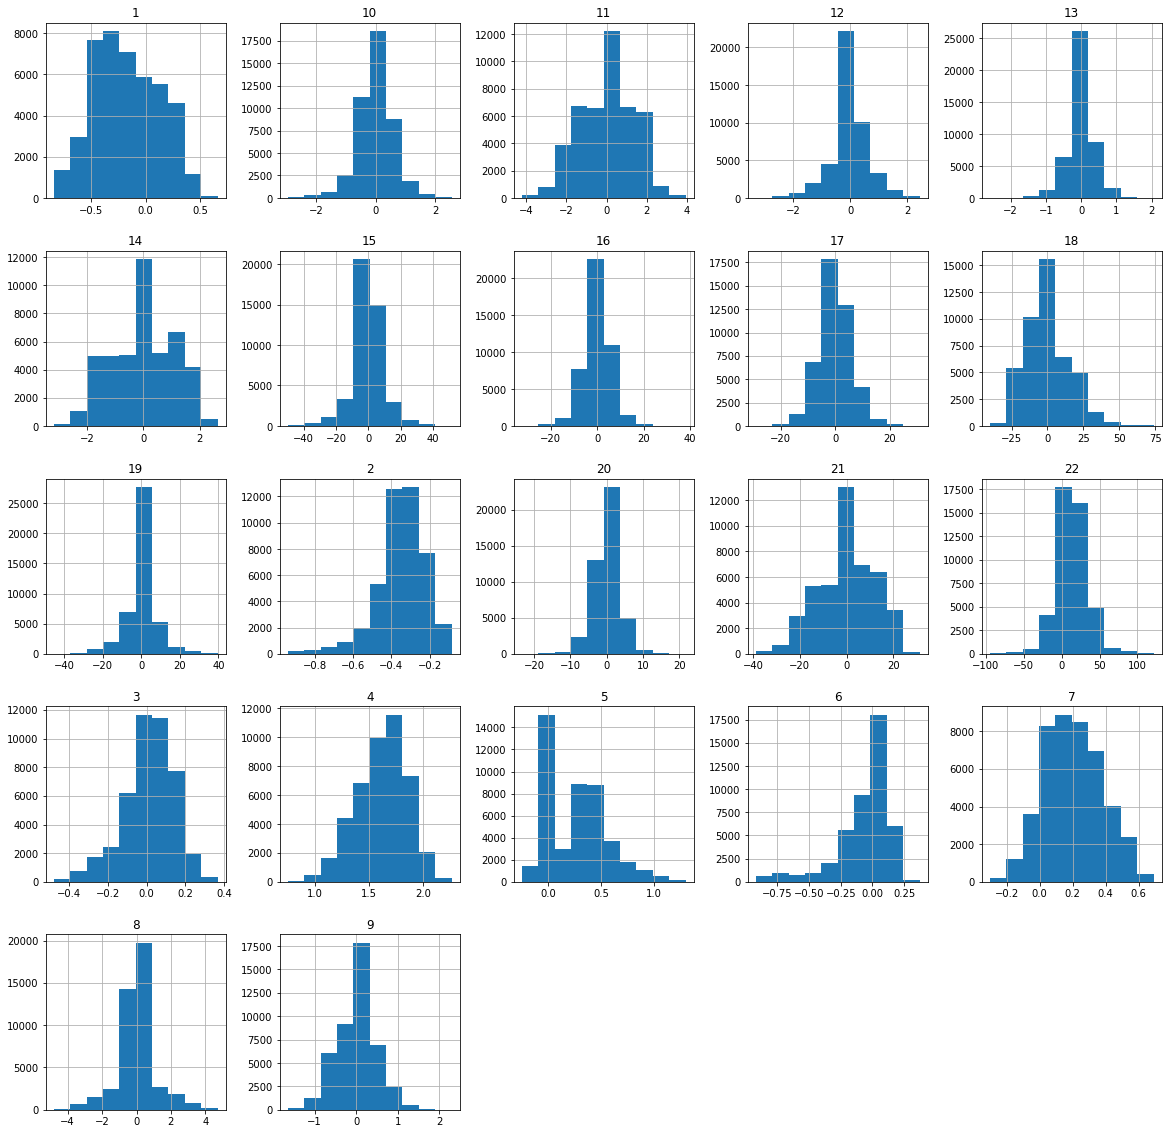

In [3]:
datadf.hist(figsize = (20, 20))
plt.show()

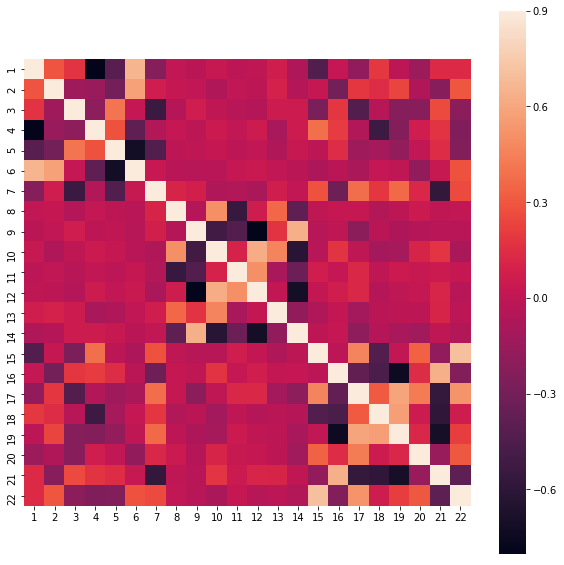

In [4]:
import seaborn as sns

corrmat = datadf.corr()
fig = plt.figure(figsize = (10, 10))

sns.heatmap(corrmat, vmax = 0.9, square = True)
plt.show()

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


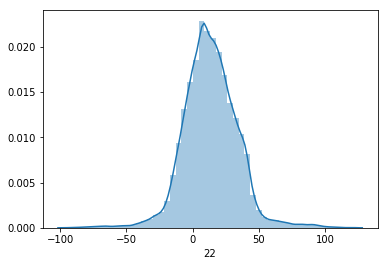

In [5]:
sns.distplot(datadf['22'])

### Gaussian Process

In [6]:
import numpy as np
import matplotlib.pyplot as plt

import math
from scipy.spatial.distance import cdist
from scipy.optimize import minimize

class GPRegressor:
    
    """ The GPRegressor object has the following properties:
    
        l : Correlation length. Scalar or array of length num_features in X
        varf : Signal variance.
        normalize_y : Subtract mean of y from y if True. Often a good idea since
                      we are modeling a zero-mean GP.
        num_restarts_hyper : Number of randomly initialized optimizations of the hyperparameters,
                             that should be performed. More than one is usually a good idea since
                             the log_marinal_likelihood often has local maxima.
        """
    
    def __init__(self,l=1.0,varf=1.0,normalize_y=True,num_restarts_hyper=1):
    
        self.varf=varf
        self.normalize_y = normalize_y
        self.num_restarts=num_restarts_hyper
        self.l=np.array(l)
        
    def predict(self,X,return_std=False):
        
        """The function returns the predicted values of 
            test data X_test using kernel K2.
            
            Parameters
            ----------
            self : GPRegressor object
            X : test dataset
            return_std : if True, function returns standard deviation values
            
            Returns
            -------
            mean : mean of each predicted value
            std2 : standard deviation of each predicted value
            """
        
        l=self.l
        self.K2 = self.kernel(X,self.X_train,np.zeros_like(X),self.var_x,l,self.varf)  # Define kernel using parameters provided
        mean=np.dot(self.K2,self.pred_vec)+self.mu                                     # Mean is the dot product between Kernel K2 and predicted values added to mean of unnormalised target values
        if return_std:
            std2=np.sqrt(np.diag(self.autokernel(X,np.zeros_like(X),l,self.varf)-np.dot(self.K2,np.dot(self.pred_fac,self.K2.T))))
            return mean,std2
        else:
            return mean,0.0


        
    def kernel(self,X1,X2,var_x1,var_x2,l,varf):
        
        """The function defines the Gaussian Process kernel.
            This is achieved by calculating the euclidean 
            distance for mean and variance and summing it 
            together. The summed mean and variance values 
            are fitted in the gaussian model.
            
            Parameters
            ----------
            self : GPRegressor object
            X1 : Training dataset
            X2 : Zeros matrix same as X1
            var_x1 : variance of X1 dataset
            var_x2 : variance of X2 dataset
            l = Correlation length
            varf = Signal variance
            
            Returns
            -------
            Gaussian Kernel fitted with traning dataset 
            """
        
        tmp_mean=0.0
        tmp_var=1.0
        l=l*np.ones(len(self.X_train[0,:]))      # Correlation matrix of shape (l, X_train[0,:])
        for i in range(0,len(X1[0,:])):
            l2=l[i]*l[i]                         # Square correlation matrix
            dist_mean=cdist(X1[:,i].reshape(-1,1),X2[:,i].reshape(-1,1),metric='sqeuclidean')
            dist_var=cdist(var_x1[:,i].reshape(-1,1),-var_x2[:,i].reshape(-1,1),metric='euclidean')
            tmp_mean+=dist_mean/(l2+dist_var)
            tmp_var*=(1.0+dist_var/l2)  
        return varf*np.power(tmp_var,-0.5)*np.exp(-0.5*tmp_mean)
        
    
    def autokernel(self,X,var_x,l,varf):
        
        """The function defines another Gaussian Process kernel.
            This is achieved by calculating the euclidean 
            distance for mean and variance and summing it 
            together. The summed mean and variance values 
            are fitted in the gaussian model.
            
            Parameters
            ----------
            self : GPRegressor object
            X : Training dataset
            var_x : variance of X1 dataset
            l = Correlation length
            varf = Signal variance
            
            Returns
            -------
            Gaussian Kernel fitted with traning dataset 
            """
        
        tmp_mean=0.0
        tmp_var=1.0
        l=l*np.ones(len(self.X_train[0,:]))
        for i in range(0,len(X[0,:])):
            l2=l[i]*l[i] #!
            dist_mean=cdist(X[:,i].reshape(-1,1),X[:,i].reshape(-1,1),metric='sqeuclidean')
            dist_var=cdist(var_x[:,i].reshape(-1,1),-var_x[:,i].reshape(-1,1),metric='euclidean')
            tmp_mean+=dist_mean/(l2+dist_var)
            tmp_var*=(1.0+dist_var/l2)  
        return varf*np.power(tmp_var,-0.5)*np.exp(-0.5*tmp_mean)  
    

    def fit(self,X_train,y_train,var_x,var_y,l_bounds=None):
        
        """The function fits the Gaussian Kernel to the training 
            feature dataset. First, the dataset is normalized and 
            then fitted with hyperparameters (noise variance, signal 
            variance and correlation length) which has been maximized 
            using log marginal likelihood.
            
            Parameters
            ----------
            X_train : Input data (num_samples, num_features)
            y_train : Ouptut data (num_samples)
            var_x : Variance in input points x
            var_y : Variance in output points y
            l_bounds : Bounds for the hyperparameters.
                      Array size (3x2) or ((2+num_features)x2).
                      l[0] is varf(signal variance), l[1] is noise_variance
                      and l[2::] is correlation length(s)
                      None means using the supplied hyperparameters.
            """
        
        # Normalization
        
        if self.normalize_y:
            self.mu=np.mean(y_train,0)
        else:
            self.mu=0.0
            
        self.X_train=X_train
        self.y_train = (y_train-self.mu)
        
        if np.iterable(var_x):
            self.var_x=var_x
        else:
            self.var_x=var_x*np.ones_like(X_train)
        
        self.var_y=var_y
        
        # Fitting hyperparameters by maximizing log marginal likelihood
        
        if l_bounds is not None:
            bounds = []
            for i in range(0,len(l_bounds)):
                bounds.append(l_bounds[i])
            best_f=1e6
            for j in range(0,self.num_restarts):
                loglb=np.log10(l_bounds[:,0])                            # Lower bound
                loghb=np.log10(l_bounds[:,1])                            # Higher bound
                l0=loglb+(loghb-loglb)*np.random.random(size=loglb.shape)
                l0=10.0**l0   
                
                # Minimize log marginal likelihood function using scipy.optimize.minimize
                res=minimize(self.neg_log_marginal_likelihood,l0,tol=1e-12,options={'disp':False,'eps':0.001})
                
                # Reassigning hyperparameter values

                self.varf=res['x'][0]
                self.alpha=res['x'][1]
                self.l=res['x'][2::]
                self.opt_params=res['x']
                
                print ("iter: "+str(j) +". params: " + str(self.varf) + ", " + str(self.alpha) + ", " + str(self.l))    
            self.var_y+=self.alpha
            
        # Calculate factors needed for prediction.
        
        self.K1=self.autokernel(self.X_train,self.var_x,self.l,self.varf)                  # Kernel fitting with new hyperparameters
        self.pred_fac = np.linalg.pinv(self.K1+ np.identity(len(self.K1[:,0]))*self.var_y) # Calculate prediction factor
        self.pred_vec = np.dot(self.pred_fac,self.y_train)                                 # Calculates values to be predicted
        
    def neg_log_marginal_likelihood(self,l):
        
        """The function defines the negative log marginal
        likelihood function. 
        
        Parameters
        ----------
        self : GPRegressor object
        l : correlation length
        
        Returns
        -------
        Negative log marginal likelihood kernel
        """
        
        varf=l[0]
        varn=l[1]
        l=l[2::]
        K=self.autokernel(self.X_train,self.var_x,l,varf)+ np.identity(len(self.X_train[:,0]))*(self.var_y+varn)     # Defining and fitting NLML kernel
        Kinv = np.linalg.pinv(K)
        return 0.5*np.dot(self.y_train,np.dot(Kinv,self.y_train))+0.5*np.log(np.linalg.det(K))+0.5*len(K[:,0])*np.log(2*math.pi)
    


#### Implementing Gaussian Process on SARCOS dataset

#### 1. One feature 1000 datapoints

C:\Program Files\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1874: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Program Files\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


iter: 0. params: 12.457139113415156, 21.905428193761292, [3.9402229]
iter: 1. params: 12.343348807459765, 31.776843103966804, [26.24111629]


C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: divide by zero encountered in log
C:\Program Files\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


iter: 2. params: 22.504646163816822, 1.8068589128133803, [34.76012087]


C:\Program Files\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1874: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Program Files\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


iter: 3. params: 3.2560738549239683, 35.987981820885125, [1.43645103]


C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: invalid value encountered in log
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: invalid value encountered in log
C:\Program Files\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1874: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Program Files\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1874: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: invalid value encountered in log


iter: 4. params: 25.87670262460637, -1030.8901382144468, [72.26696742]
Mean Squared Error is:  1.0282104420825942


C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in sqrt


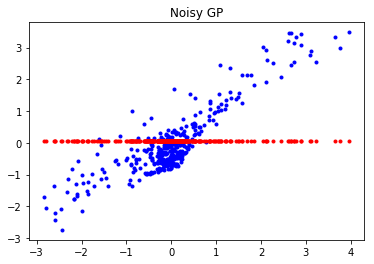

Runtime:  57.1284186  seconds


In [7]:
import timeit
start_time = timeit.default_timer()


y = datadf['22'][:1000].values
x = datadf['15'][:1000].values

x = (x - x.mean())/x.std()
y = (y - y.mean())/y.std()
X = pandas.DataFrame(x,columns=['x'])
X = X.values

split = int(X.shape[0] * 0.6)

X_train = X[:split,:]
y_train = y[:split]

X_test = X[split:,:]
y_test = y[split:]
   
    
l_bounds=np.array([[1,100],[1,100],[1,90.0]])
gp=GPRegressor(1,1,num_restarts_hyper=5)
gp.fit(X_train,y_train,0.01,0.01,l_bounds=l_bounds)
y_pred,std=gp.predict(X_test,True) 
mse = np.mean((y_test - y_pred)**2)
print('Mean Squared Error is: ', mse)
    
plt.figure()
plt.plot(X_test[:,0],y_test,'b.')
plt.plot(X_test[:,0],y_pred,'r.')
plt.title('Noisy GP')
plt.show()


elapsed = timeit.default_timer() - start_time
print('Runtime: ' , elapsed, ' seconds')

#### 2. Three features 5000 datapoints

C:\Program Files\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1874: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Program Files\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


iter: 0. params: 62.065547005518034, 14.756608032806348, [30.36880221]
iter: 1. params: 19.954049702057247, 21.381251967556178, [10.19458181]
iter: 2. params: 23.610665732665712, 2.062125921816529, [70.71141704]
iter: 3. params: 30.745362316324304, 8.252317827254627, [6.16449109]
iter: 4. params: 18.755126382383764, 1.7781313934185217, [77.11755956]
Mean Squared Error is:  227.09839076690545


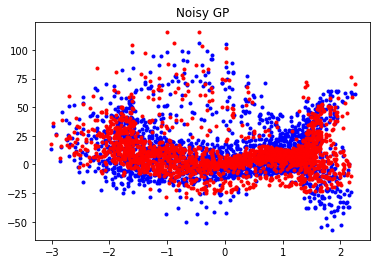

Runtime:  300.4860728  seconds


In [8]:
import timeit
start_time = timeit.default_timer()


y = datadf['22'][:5000].values
x = datadf[['14','15','17']][:5000].values

X = pandas.DataFrame(x,columns=[['14','15','17']])
X = X.values

split = int(X.shape[0] * 0.6)

X_train = X[:split,:]
y_train = y[:split]

X_test = X[split:,:]
y_test = y[split:]
   
    
l_bounds=np.array([[1,100],[1,100],[1,90.0]])
gp=GPRegressor(1,1,num_restarts_hyper=5)
gp.fit(X_train,y_train,0.01,0.01,l_bounds=l_bounds)
y_pred,std=gp.predict(X_test,True) 
mse = np.mean((y_test - y_pred)**2)
print('Mean Squared Error is: ', mse)
    
plt.figure()
plt.plot(X_test[:,0],y_test,'b.')
plt.plot(X_test[:,0],y_pred,'r.')
plt.title('Noisy GP')
plt.show()


elapsed = timeit.default_timer() - start_time
print('Runtime: ' , elapsed, ' seconds')

#### 3. Three features 10000 datapoints

C:\Program Files\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1874: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Program Files\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


iter: 0. params: 4.898822136128861, 4.419864168060356, [24.29729247]
iter: 1. params: 8.557037665329956, 64.9445946028725, [2.90344523]
iter: 2. params: 11.339109554517988, 1.0625971769421618, [6.33287252]
iter: 3. params: 7.445486203355335, 20.483099177998685, [3.58325991]
iter: 4. params: 3.1932111829859626, 5.665635910160154, [76.18565567]
Mean Squared Error is:  254.7405086601652


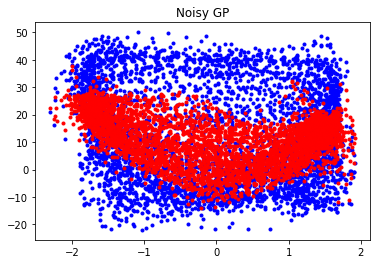

Runtime:  2099.7947045  seconds


In [9]:
import timeit
start_time = timeit.default_timer()


y = datadf['22'][:10000].values
x = datadf[['14','15','17']][:10000].values


X = pandas.DataFrame(x,columns=[['14','15','17']])
X = X.values

split = int(X.shape[0] * 0.6)

X_train = X[:split,:]
y_train = y[:split]

X_test = X[split:,:]
y_test = y[split:]
   
    
l_bounds=np.array([[1,100],[1,100],[1,90.0]])
gp=GPRegressor(1,1,num_restarts_hyper=5)
gp.fit(X_train,y_train,0.01,0.01,l_bounds=l_bounds)
y_pred,std=gp.predict(X_test,True) 
mse = np.mean((y_test - y_pred)**2)
print('Mean Squared Error is: ', mse)
    
plt.figure()
plt.plot(X_test[:,0],y_test,'b.')
plt.plot(X_test[:,0],y_pred,'r.')
plt.title('Noisy GP')
plt.show()


elapsed = timeit.default_timer() - start_time
print('Runtime: ' , elapsed, ' seconds')

### Toy Problem 1: Exponential Sinusoidal Waveform

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: divide by zero encountered in log
C:\Program Files\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: divide by zero encountered in log
C:\Program Files\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: invalid value encountered in log
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: invalid value encountered in log


iter: 0. params: -0.05666974569206784, 0.5700876602986364, [16.3563832]


C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: invalid value encountered in log


iter: 1. params: -1244.4191078387244, -0.13352417628047908, [-181.17363726]


C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: invalid value encountered in log
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: invalid value encountered in log
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: invalid value encountered in log
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: invalid value encountered in log
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: invalid value encountered in log
C:\Program Files\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1874: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Program Files\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


iter: 2. params: -0.41037927492965787, 0.25829459560072904, [1.40975912]


C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: invalid value encountered in log


iter: 3. params: 0.03864473915681105, 0.0860519619588125, [0.5412015]


C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: invalid value encountered in log
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: divide by zero encountered in log
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: invalid value encountered in log
C:\Program Files\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1874: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: divide by zero encountered in log
C:\Program Files\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: invalid value encountered in log
C:\Program Files\Anaconda3\lib\site-packa

iter: 4. params: 3.147011810761145, -60.80401609535743, [2659.17897164]
iter: 5. params: 0.07440599452811376, 0.05822152834909289, [2.18592919]


C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: invalid value encountered in log
C:\Program Files\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1874: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: divide by zero encountered in log
C:\Program Files\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: invalid value encountered in log
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: divide by zero encountered in log
C:\Program Files\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,

iter: 6. params: 0.03653167884259092, 0.9926113812710955, [1.78988221]
iter: 7. params: 0.2357124918987947, 0.07002547826244795, [0.34726327]


C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: invalid value encountered in log
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: invalid value encountered in log
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: invalid value encountered in log


iter: 8. params: 0.16136385027870617, 0.076835367460918, [4.54565328]
iter: 9. params: 0.9915775284625263, -0.17959420215958977, [0.50130057]
0.4453065662455


C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: divide by zero encountered in log
C:\Program Files\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in sqrt


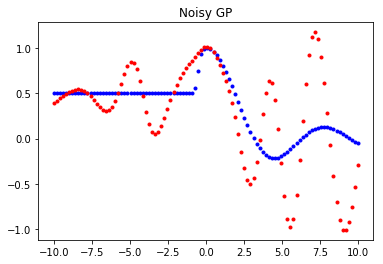

In [10]:
##Example insipired from 'Learning Gaussian Process Models from Uncertain Data', Dallaire.
if __name__=="__main__":
    def sincsig(x):
        return (x>=0)*np.sinc(x/math.pi)+(x<0)*(0.5*(1 + np.exp(-10*x-5))**(-1)+0.5)
        
        
    X_train=np.random.random((150,1))*20.0-10.0
    y_train=sincsig(X_train[:,0])
    
    X_std = np.random.random(X_train.shape)*2.0+0.5
    y_std= 0.1*np.ones_like(y_train)
    y_train += np.random.normal(0.0,y_std)
    X_train += np.random.normal(0.0,X_std)
    
    Xcv=np.linspace(-10,10,100).reshape(-1,1)
    ycv=sincsig(Xcv[:,0])
    
    l_bounds=np.array([[0.01,0.3],[0.01,0.1],[0.1,5.0]])
    gp=GPRegressor(1,1,num_restarts_hyper=10)
    gp.fit(X_train,y_train,X_std**2,0.0,l_bounds=l_bounds)
    yp,std=gp.predict(Xcv,True)
    print (np.sqrt(np.average((yp-ycv)**2)))  
    
    plt.figure()
    plt.plot(Xcv[:,0],sincsig(Xcv),'b.')
    plt.plot(Xcv[:,0],yp,'r.')
    plt.title('Noisy GP')


### Toy Problem 2: Abalone Age Prediction

In [11]:
import pandas

abalonedf = pandas.read_csv('abalone.csv')

toyprob2df = abalonedf[['Length','Height','Whole weight','Rings']][:500]
toyprob2df.head()



,Length,Height,Whole weight,Rings
0,0.455,0.095,0.5140,15
1,0.350,0.090,0.2255,7
2,0.530,0.135,0.6770,9
3,0.440,0.125,0.5160,10
4,0.330,0.080,0.2050,7


C:\Program Files\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1874: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Program Files\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Program Files\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1874: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Program Files\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1874: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Program Files\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Program Files\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1874: RuntimeWarning: overflow encountered in det
  r = _umath

iter: 0. params: 8.588255943541782, 10.342306847583139, [4.1029113]
iter: 1. params: 11.2483570321128, 52.901994181142534, [1.46680895]


C:\Program Files\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1874: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Program Files\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


iter: 2. params: 87.34626415416943, 5.63218290575989, [-1.04646642]
iter: 3. params: 38.25807000513015, 47.12535166312074, [2.55495445]


C:\Program Files\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1874: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Program Files\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


iter: 4. params: 34.662423156573034, 80.53391090301085, [6.43654203]
Mean Squared Error is:  14.723742073874865


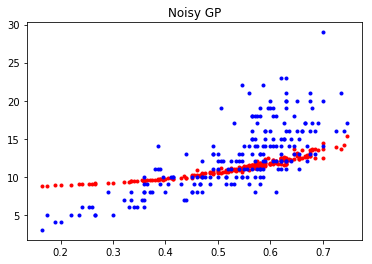

Runtime:  11.089048599999842  seconds


In [12]:
import timeit
start_time = timeit.default_timer()


y = toyprob2df['Rings'].values
x = toyprob2df[['Length','Height','Whole weight']].values

X = pandas.DataFrame(x,columns=[['Length','Height','Whole weight']])
X = X.values

split = int(X.shape[0] * 0.6)

X_train = X[:split,:]
y_train = y[:split]

X_test = X[split:,:]
y_test = y[split:]
   
    
l_bounds=np.array([[1,100],[1,100],[1,90.0]])
gp=GPRegressor(1,1,num_restarts_hyper=5)
gp.fit(X_train,y_train,0.01,0.01,l_bounds=l_bounds)
y_pred,std=gp.predict(X_test,True) 
mse = np.mean((y_test - y_pred)**2)
print('Mean Squared Error is: ', mse)
    
plt.figure()
plt.plot(X_test[:,0],y_pred,'r.')
plt.plot(X_test[:,0],y_test,'b.')
plt.title('Noisy GP')
plt.show()


elapsed = timeit.default_timer() - start_time
print('Runtime: ' , elapsed, ' seconds')

### Comparison to SKLearn Model

In [13]:
import pandas

datadf = pandas.read_csv('sarcos_inv.csv')
datadf.columns = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22']
datadf.head()



,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
0,0.017279,-0.137077,0.026999,1.532517,0.301344,0.058259,0.128653,-0.153640,-0.335279,0.006449,...,0.017012,-2.211089,11.989628,-7.781117,11.613101,9.550076,14.643369,1.015070,-17.048688,44.104164
1,0.016336,-0.140878,0.027250,1.549670,0.302318,0.059027,0.104104,-0.047313,-0.418732,0.106274,...,0.015857,-2.337160,9.961797,-5.468357,9.550884,5.933340,15.467628,0.910548,-11.415526,37.354858
2,0.016273,-0.145307,0.029072,1.566855,0.307628,0.059027,0.080321,0.053238,-0.460963,0.188013,...,0.007958,-2.331961,7.332938,-2.434889,7.664916,3.964112,10.309203,0.921360,-5.772058,30.676065
3,0.017279,-0.150051,0.031083,1.584416,0.314162,0.059027,0.058840,0.133810,-0.462264,0.263975,...,-0.001271,-2.249311,3.797804,0.467865,6.160604,3.175643,2.868096,1.059957,-0.491542,25.920128
4,0.018818,-0.154544,0.034256,1.602449,0.319723,0.058259,0.036592,0.140750,-0.435916,0.318977,...,-0.006587,-2.123942,0.373019,2.622800,4.442314,2.821629,-1.571357,1.306848,4.210767,17.594261


In [14]:
import timeit
start_time = timeit.default_timer()

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

split = int(X.shape[0] * 0.6)

X_train = X[:split,:]
y_train = y[:split]

X_test = X[split:,:]
y_test = y[split:]

kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(X_train, y_train)
y_pred, std = gpr.predict(X_test, return_std=True) 

mse = np.mean((y_test - y_pred)**2)
print('Mean Squared Error is: ', mse)

elapsed = timeit.default_timer() - start_time
print('Runtime: ' , elapsed, ' seconds')

Mean Squared Error is:  10.00396820627446
Runtime:  0.38588099999969927  seconds
